In [ ]:
!pip install tensorflow

In [280]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler as sc
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler as sc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.pipeline import Pipeline  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [281]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/jbrablx/ai_insurance/raw/train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [282]:
#Creating Bins
age=pd.cut(df['Age'],bins=5,labels=['A1','A2','A3','A4','A5'])
rc=pd.cut(df['Region_Code'],bins=5,labels=['A1','A2','A3','A4','A5'])
ap=pd.cut(df['Annual_Premium'],bins=5,labels=['A1','A2','A3','A4','A5'])
vin=pd.cut(df['Vintage'],bins=5,labels=['A1','A2','A3','A4','A5'])

In [283]:
#Adding columns to our dataset
df['age']=age             
df['rc']=rc 
df['ap']=ap
df['vin']=vin

In [284]:
#Creating dummy columns
df_dum=pd.get_dummies(df[['age','rc','ap','vin','Gender','Vehicle_Age','Vehicle_Damage','Vehicle_Damage']])

In [285]:
df=pd.concat([df,df_dum],axis=1)

In [286]:
df.drop(['Gender','Age','age','Region_Code','rc','Vehicle_Age','Vehicle_Damage','Annual_Premium','ap','Vintage','vin'],axis=1,inplace=True)

In [287]:
#Dividing the data for train and test
X_train, X_test, Y_train, y_test = train_test_split(df, df['Response'], test_size=0.1, random_state=42)

In [288]:
#Scaling the data using the sklearn StandardScaler to set the mean to 0 and standard deviation to 1.
scaler=sc()
scaled_df_train=scaler.fit_transform(X_train.drop(['id','Response'],axis=1))
scaled_df_test=scaler.fit_transform(X_test.drop(['id','Response'],axis=1))

In [289]:
#Dividing train data
X_train, X_val, y_train, y_val = train_test_split(scaled_df_train, Y_train, test_size=0.15, random_state=42)

**SGDClassifier**, which stands for Stochastic Gradient Descent Classifier, is a linear classifier that uses stochastic gradient descent (SGD) as its optimization algorithm. It's a part of scikit-learn machine learning library. It uses *stochastic gradient descent*, which is an iterative optimization algorithm. SGD updates the model parameters based on the gradient of the loss function with respect to the parameters. It processes one training example at a time, making it particularly useful for large datasets. SGDClassifier is often used for linear classification tasks, where the decision boundary is a linear combination of the input features. You can specify different loss functions based on the type of classification problem you are working on. Common choices include 'hinge' (for linear SVM), 'log' (for logistic regression), and 'modified_huber' (a smooth approximation of the hinge loss). It supports L1 and L2 regularization, which helps prevent overfitting by penalizing large coefficients. Due to its stochastic nature, SGD is suitable for large datasets, as it processes one example at a time rather than the entire dataset.

In [290]:
#Selecting the right model with tuned Hyper-Parameters
sgc=SGDClassifier(penalty='l1',loss='modified_huber',early_stopping=True)
model_params={'alpha':[0.0012,0.0011,0.0013],
              'learning_rate':['invscaling'],
              'max_iter':[690,700,710],
              'validation_fraction':[0.46,0.47,0.48],
              'eta0':[0.65,0.66,0.64]}
ran=RandomizedSearchCV(sgc,param_distributions=model_params,cv=5,n_jobs=-1,verbose=2,n_iter=100)

In [291]:
ran.fit(scaled_df_train, Y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(early_stopping=True,
                                           loss='modified_huber',
                                           penalty='l1'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0012, 0.0011, 0.0013],
                                        'eta0': [0.65, 0.66, 0.64],
                                        'learning_rate': ['invscaling'],
                                        'max_iter': [690, 700, 710],
                                        'validation_fraction': [0.46, 0.47,
                                                                0.48]},
                   verbose=2)

In [292]:
ran.best_params_

{'validation_fraction': 0.46,
 'max_iter': 690,
 'learning_rate': 'invscaling',
 'eta0': 0.66,
 'alpha': 0.0011}

In [293]:
ran.best_score_

0.8777689666616615

In [294]:
y_pred=ran.predict(scaled_df_test)

In [298]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.45%


In [295]:
# Confusion matrix
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

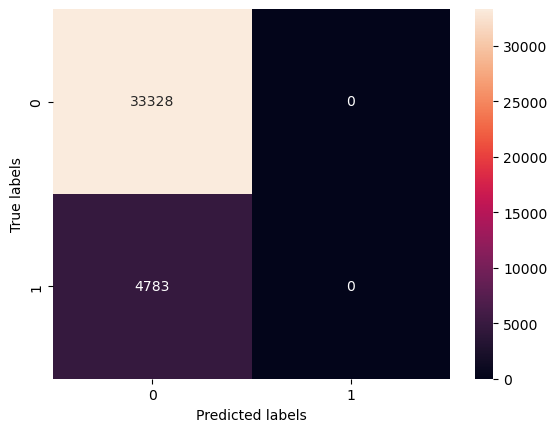

In [297]:
plot_confusion_matrix(y_test, y_pred)

If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, we have no false and true positives, it could be acceptable. However, we need to decrease as much as possible the false negative responses (4783 cases) because they refer to the customers that want an auto subscription while the model flagged them as customers that don't want the auto insurance.

**CLASS WEIGHT**

The goal is to identify the customers interested in auto insurance, but we don't have many of those positive samples to work with, so we would want to have the classifier heavily weight the few examples that are available. We will do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [303]:
neg, pos = np.bincount(Y_train)
print(pos,neg)

41927 301071


In [304]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all stays the same.
weight_for_0 = (1 / neg)*(neg+pos)/2.0 
weight_for_1 = (1 / pos)*(neg+pos)/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}\n'.format(weight_for_0),
      'Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
 Weight for class 1: 4.09


In [305]:
#Selecting the right model with tuned Hyper-Parameters and class weights
sgc_weighted=SGDClassifier(penalty='l1',loss='modified_huber',early_stopping=True, class_weight=class_weights)
model_params={'alpha':[0.0012,0.0011,0.0013],
              'learning_rate':['invscaling'],
              'max_iter':[690,700,710],
              'validation_fraction':[0.46,0.47,0.48],
              'eta0':[0.65,0.66,0.64]}
ran=RandomizedSearchCV(sgc_weighted,param_distributions=model_params,cv=5,n_jobs=-1,verbose=2,n_iter=100)

In [306]:
ran.fit(scaled_df_train, Y_train)

/opt/mamba/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(class_weight={0: 0.5696297551075992,
                                                         1: 4.090419061702483},
                                           early_stopping=True,
                                           loss='modified_huber',
                                           penalty='l1'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.0012, 0.0011, 0.0013],
                                        'eta0': [0.65, 0.66, 0.64],
                                        'learning_rate': ['invscaling'],
                                        'max_iter': [690, 700, 710],
                                        'validation_fraction': [0.46, 0.47,
                                                                0.48]},
                   verbose=2)

In [307]:
ran.best_params_

{'validation_fraction': 0.47,
 'max_iter': 690,
 'learning_rate': 'invscaling',
 'eta0': 0.66,
 'alpha': 0.0011}

In [308]:
ran.best_score_

0.6744004497001355

In [309]:
y_weight_pred=ran.predict(scaled_df_test)

In [311]:
weight_accuracy = accuracy_score(y_test, y_weight_pred)
print("Accuracy: %.2f%%" % (weight_accuracy * 100.0))

Accuracy: 64.25%


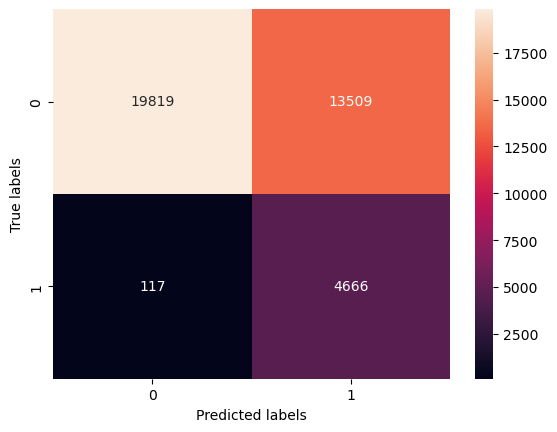

In [310]:
plot_confusion_matrix(y_test, y_weight_pred)

In this case, the number of false negatives dropped considerably from 4783 to 117 cases.